In [3]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [4]:
cd ..

/home/dfernandes/Documents/Bath/Projects/Francisco/ControlledFollmerDrift


In [5]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, gaussian_prior
from cfollmer.sampler_utils import FollmerSDE

## Loading the iris dataset

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

iris = load_iris()
X = iris['data']
y = iris['target']

# Binary classification
X = X[~(y==2)][:,[0,1]]
y = y[~(y==2)]

# dummy dims 
X = np.concatenate((torch.ones(X.shape[0],1), torch.tensor(X) ), axis=1)

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

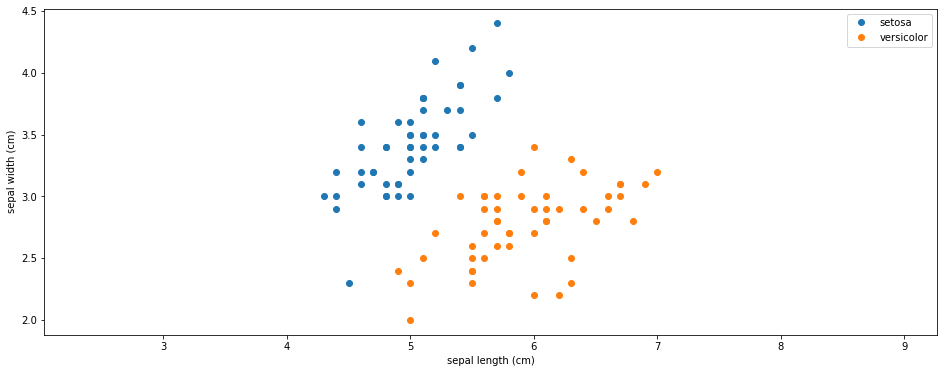

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
for target, target_name in enumerate(names[0:2]):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 1], X_plot[:, 2], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation. However results are a bit strange. The weights sampled at $\Theta_1^{\mathbf{u}^*}$ are too large (despite the perfect predictive accuracy). So something is off. Its as though the girsanov factor is failing to regularize the model. This needs more investigation.

### Note on the bug

I have a MAP baseline implemented further down. It seems to be the case that the map baseline is also converging to similar large values as the CSF sampler so whatever the bug is its in both places. 

### Maybe there is no bug

I just tweakted $p(\theta)$ to be much more confident and now the weights are much smaller which is expected behaviour and we see the same behaviour in MAP. So maybe there is no bug , I still find that when $\sigma_w=1$ the prior is having less effect than I would expect so stil not completely sure we are bug free. 

In [8]:
def log_likelihood(Θ, X, y):
    """
    Slow implementation of logistic log likleihood
    as a function of the parameters
    """
    logits = X.mm(Θ.T)
    
    vector_loss = - (torch.einsum("a,ab->b", y, torch.nn.functional.logsigmoid(logits)) +
                     torch.einsum("a,ab->b", (1-y), torch.log(1-torch.sigmoid(logits)))
                    )
    return vector_loss


def log_likelihood_vmap(Θ, X, y):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    logits = X.mm(Θ.T)
    
    pos_weights = torch.ones(logits.shape[0], device=device)
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    
    loss_ = lambda x: loss(x, y)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(logits.T)

In [9]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = 3

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [10]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              gaussian_prior, log_likelihood_vmap, γ=1.0, device=device)

/tmp/ipykernel_27535/3526744317.py:27: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


tensor(-56.6557, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.05, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 100
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood_vmap, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            gaussian_prior, log_likelihood_vmap, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

20


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_27535/3526744317.py:27: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


In [12]:
losses

[-66.75397491455078,
 -90.76818084716797,
 -100.66091918945312,
 -124.49198913574219,
 -147.5787811279297,
 -154.7216339111328,
 -156.56861877441406,
 -159.95220947265625,
 -161.1800537109375,
 -164.45144653320312,
 -168.00634765625,
 -169.83412170410156,
 -168.6304473876953,
 -168.46478271484375,
 -168.14393615722656,
 -166.9335174560547,
 -168.6015625,
 -170.6217803955078,
 -169.615478515625,
 -171.107421875,
 -170.333984375,
 -169.7887420654297,
 -169.98056030273438,
 -170.27894592285156,
 -168.89796447753906,
 -169.99264526367188,
 -170.1310577392578,
 -170.50120544433594,
 -171.05421447753906,
 -171.11875915527344,
 -171.00135803222656,
 -169.49644470214844,
 -171.87774658203125,
 -172.35569763183594,
 -170.8623046875,
 -172.06588745117188,
 -170.9447479248047,
 -170.3451690673828,
 -170.91468811035156,
 -171.39942932128906,
 -171.1105194091797,
 -170.78822326660156,
 -172.5971221923828,
 -170.81214904785156,
 -171.6849822998047,
 -171.35096740722656,
 -170.582763671875,
 -170.984

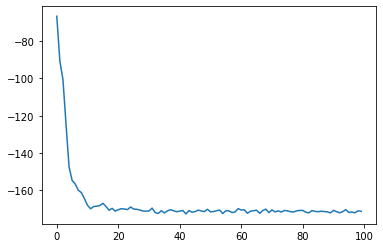

In [13]:
plt.plot(losses[:])

In [14]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 3])

In [15]:
X_train.shape

torch.Size([80, 3])

In [16]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([5., 5., 1., 4., 7., 5., 6., 6., 3., 8.]),
 array([0.8359744, 1.2240739, 1.6121733, 2.0002728, 2.3883722, 2.7764716,
        3.1645713, 3.5526707, 3.9407701, 4.3288693, 4.716969 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

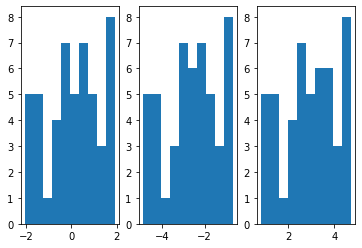

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [18]:
pred = torch.sigmoid(X_train.mm(Θ_1.T)).mean(axis=1)

In [19]:
((pred < 0.5).float() == y_train).float().mean()

tensor(0.9875, device='cuda:0')

In [20]:
pred_test = torch.sigmoid(X_test.float().mm(Θ_1.T)).mean(axis=1)

In [21]:
((pred_test < 0.5).float() == y_test).float().mean()

tensor(1., device='cuda:0')

In [22]:
Θ_1.mean(axis=0)

tensor([ 0.1014, -2.5885,  2.9401], device='cuda:0', grad_fn=<MeanBackward1>)

In [23]:
y_test, (pred_test < 0.5).long()

(tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1.], device='cuda:0'),
 tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        device='cuda:0'))

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [25]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train + gaussian_prior(Θ_map)))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        losses_map.append(loss.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_27535/3526744317.py:27: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


(tensor(0.9875, device='cuda:0'),
 tensor([[ 0.0000, -2.1514,  2.0305]], device='cuda:0', requires_grad=True))

## Pyro Bayesian Logistic Regeression

As a baseline we run pyro with SVI on this same example atm we get very different results which is a bit worrying.

#### EDIT:

I think results are actually in agreement what was happening is the priors in the pyro code where much more confident thus the smaller weights. I just tried changing the prior of this pyro model and the posterior is not changing much, this is a bit fishy maybe worth investigating. 

I think it might just be the case that this model is not very good.

In [ ]:
import numpy as np
import scipy.special as ssp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

pyro.enable_validation(True)
torch.set_default_dtype(torch.double) # this was necessary on the CPU

In [ ]:

# these were adapted from the Pyro VAE tutorial

def train(svi, train_loader, n_train):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(*xs)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(*xs)

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker='o', label='Train ELBO')
    plt.plot(x[::test_int], test_elbo, marker='o', label='Test ELBO')
    plt.xlabel('Training Epoch')
    plt.legend()
    plt.show()

In [ ]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()
        
        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 0.0001 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale =  0.0001 * torch.ones(1)
        
        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight", dist.Normal(self.alpha_h_loc, self.alpha_h_scale, validate_args=True).independent(1)
        ).float()
        b = pyro.sample(
            "bias", dist.Normal(self.beta_h_loc, self.beta_h_scale, validate_args=True).independent(1)
        ).float()

        with pyro.iarange("data", x.size(0)):
#             import pdb; pdb.set_trace()
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()
            
            pyro.sample(
                "obs", 
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze()
            )
            
    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)

        pyro.sample(
            "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )
    
    
    def guide_(self, x, y, N=100):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)
        w = []
        b = []
        for _ in range(N):
            w.append(torch.tensor(pyro.sample(
                "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
            )))
            b.append(torch.tensor(pyro.sample(
                "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
            )))
#         import pdb;pdb.set_trace()
        return torch.vstack(w), torch.vstack(b)

In [ ]:

pyro.clear_param_store()

optim = Adam({'lr': 0.01})

num_epochs = 1000
batch_size = 50

N = X.shape[0]
p = 2

n_train = X_train.shape[0]
example_indices = np.random.permutation(N)
n_test = N - n_train
test_iter = 50

In [ ]:
lr_model = LogRegressionModel(p=p)

svi = SVI(
    lr_model.model, lr_model.guide, optim,
    loss=Trace_ELBO()
)


lr_dataset = torch.utils.data.TensorDataset(torch.tensor(X[:,1:]).float(), torch.tensor(y.reshape(-1,1)).float())

data_loader_train = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
)
    
data_loader_test = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
)

train_elbo = []
test_elbo = []
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, data_loader_train, n_train)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test)
        test_elbo.append(-total_epoch_loss_test)

In [ ]:
plot_llk(train_elbo, test_elbo, test_iter)

In [ ]:
W, b = lr_model.guide_(X_train.float(), y_train.float())

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

# ax1.hist(Θ_1[:,0].detach().numpy())
# ax2.hist(Θ_1[:,1].detach().numpy())
# ax3.hist(Θ_1[:,2].detach().numpy())


ax1.hist(b.detach().numpy(), color="red")
ax2.hist(W[:,0].detach().numpy(), color="red")
ax3.hist(W[:,1].detach().numpy(), color="red")


In [ ]:
b.mean(), W.mean(axis=0)